In [17]:
#import helper functions
from helpers import Vector, vector_dot_product, mean, variance_of_data


# Probability and Simulation: Conditional Probabilities & Dice Rolls
Probability is a measure of the likelihood of an event happening. We use it to quantify uncertainity associated with events chosen from some universe of events (all possible outcomes). E.g. of an event "the die rolls a 5"

We can think of this as
$$
P(E) = \frac{\text{\# ways the event E can occur}}{\text{\# total outcomes}}
$$


## Simulating Probability with Python

In this section we explore probability concepts (conditional probability, expectation, variance) using Python simulations.

We will:
1. Simulate the "two children" problem (conditional probability).
2. Compute expectation and variance of a fair and unfair die.
3. Use both `random.choices` and a **CDF + inverse transform** method (via `bisect`) to simulate rolls.


In [14]:
import enum, random

#used to build an Enumerate object
class Kid(enum.Enum):
    BOY=0
    GIRL=1

def random_kid() -> Kid:
    return random.choice([Kid.BOY, Kid.GIRL])
    
older_girl=0
both_girls=0
either_girl=0

random.seed(0) #fixed random number sequence

for _ in range(10000):
    younger = random_kid()
    older = random_kid()

    if older == Kid.GIRL:
        older_girl +=1

    if older==Kid.GIRL and younger == Kid.GIRL:
        both_girls +=1

    if older==Kid.GIRL or younger == Kid.GIRL:
        either_girl +=1
    

print(f"P(both | older), {both_girls/older_girl}")
print(f"P(both | either), {both_girls/either_girl}")

P(both | older), 0.5007089325501317
P(both | either), 0.3311897106109325


## Expected Value and Variance

For a random variable $X$ with values $x_i$ and probabilities $p_i
$:

$$
E[X] = \sum_i x_i p_i, \quad
\text{Var}(X) = \sum_i (x_i - \mu)^2 p_i
$$

The example will be based on a die throw. The possible outcomes of the random variable $X$ is ${1,2,3,4,5,6}$, and we can provide the probabilities of a:
- **Uniform fair die** $P = \{1/6,1/6,1/6,1/6,1/6,1/6,1/6\}$ therefore → expect mean = 3.5, var ≈ 2.92
- **Unfair die** $P = \{0.1,0.1,0.1,0.1,0.1,0.5\}$ with higher weight on 6 → higher mean, lower variance (distribution concentrated at 6). Expect mean = 4.5 variance = 3.25

In [15]:
def expected_value(values: Vector, prob: Vector) -> float:
    return vector_dot_product(values, prob)

def variance_weighted(values: Vector, prob: Vector) -> float:
    """The sample variance: almost the average squared deviation/difference from the mean"""
    assert len(values) >=2, "variance requires at least two elements"
    #find the mean
    x_bar=expected_value(values, prob)
    
    #find the sum of the squared differences between the vector and the value X-bar.
    value = sum(((x_i-x_bar)**2)*p_i for x_i, p_i in zip(values,prob))
    return value

def normalise_probabilities(prob: Vector) -> Vector:
    """Ensure probabilities are valid and sum to 1."""
    total = sum(prob)
    print(f"total probab: {total}")
    if total <=0:
        raise ValueError("Probabilities must sum to a positive number")
        
    return [p/total for p in prob]
    
values = [1,2,3,4,5,6]
probs= [1/6,1/6,1/6,1/6,1/6,1/6]
#probs2 =normalise_probabilities([1/6,1/6,1/6,1/6,1/6,1/2])
probs2 =normalise_probabilities([0.1,0.1,0.1,0.1,0.1,0.5])

print(f"total normalised prob: {sum(probs2)}")

#fair dice
ex_value = expected_value(values,probs)
var_value = variance_weighted(values, probs)
print(f"Fair dice: E[x]: {ex_value} VAR[x]: {var_value}")


#unfair dice
ex_value2 = expected_value(values,probs2)
var_value2 = variance_weighted(values, probs2)

print(f"Unfair dice: E[x]: {ex_value2} VAR[x]: {var_value2}")

total probab: 1.0
total normalised prob: 1.0
Fair dice: E[x]: 3.5 VAR[x]: 2.9166666666666665
Unfair dice: E[x]: 4.5 VAR[x]: 3.25


## Simulation vs Theory

We can compare theoretical values with simulated dice rolls.

- **Uniform fair die** → expect to converge to mean = 3.5, var ≈ 2.92 as we increase sampling quantity, $n$.
- **Unfair die** with higher weight on 6 → higher mean, lower variance (distribution concentrated at 6).

We simulate using to different methods:
1. `random.choices` with weights. Which is essentially using the approx sample versions for the mean and var
    $$
   E[X] \approx \bar{x} = \frac{\sum_i x_i}{n}, \quad
   \text{Var}(x) \approx s^2 = \frac{\sum_i (x_i - \mu)^2}{n-1}
   $$
   where $\bar{x}$ and $s^2$ are the approximated versions and $n$ is the number of samples taken. When we have a sample from a larger population $\bar{x}$ is only an estimate of the actual mean $\mu$. Therefore on average $(x-\bar{x})^2$ is an underestimate of $x_i$ standard deviation from the mean, therefore we divide it by $(n-1)$ instead of $n$.

   
3. Inverse transform sampling: generate uniform random number, map to interval in the **CDF** (using `bisect`). E.g. use the Cumulative Distrbiution Function (CDF) and take the inverse transform sampling.
#create the CDF. e.g. say we have prob = [0.1,0.1,0.1,0.1,0.1,0.6] then the cumulative sums are

up to 1 = 0.1
up to 2 = 0.1+0.1=0.2
up to 3 = 0.2+0.1=0.3
up to 4 = 0.3+0.1=0.4
up to 5 = 0.4+0.1=0.5
up to 6 = 0.5+0.5=1.0


In [18]:


#lets create a simulated version and see how the mean and variance stack up.
#create a roll the die function
def roll_die() -> int:
    return random.choice([1,2,3,4,5,6])

#create an agregator that builds a vector of all the rolls
def dice_simulation(num_of_rolls: int) -> Vector:
    return [roll_die() for _ in range(num_of_rolls)]

num_of_rolls = 100000
sim_rolls = dice_simulation(num_of_rolls)

#print(f"Rolls: {sim_rolls}")


#feed that vector into our mean and variance functions to get the results
sim_mean = mean(sim_rolls)
sim_var = variance_of_data(sim_rolls)

print(f"Roll of die Simualtion: Based on {num_of_rolls} rolls, the mean: {sim_mean}, var: {sim_var}")

#if we wanted to do the same for an unfair dice we can just simply define the probabilities and skew the random generator with weights
def unfair_dice_simulation(num_of_rolls: int, probs: Vector) -> Vector:
    return random.choices([1,2,3,4,5,6], weights=probs, k=num_of_rolls)
            
sim_probs = probs2
unfair_sim_rolls = unfair_dice_simulation(num_of_rolls, sim_probs)
#print(f"Rolls: {unfair_sim_rolls}")

sim_mean_unfair = mean(unfair_sim_rolls)
sim_var_unfair = variance_of_data(unfair_sim_rolls)


print(f"Roll of unfair die Simualtion: Based on {num_of_rolls} rolls, the mean: {sim_mean_unfair}, var: {sim_var_unfair}")


import bisect

cum_prob: float =0.0
CDF = []
for p_i in probs2:
    cum_prob += p_i
    CDF.append(cum_prob)
    
print(f"CDF {CDF}")

def roll_die_bisect() -> float: 
    #now that we've got the CDF we will draw a random variable from a uniform distributions. Assume we get r=0.26, then it will lie 
    r = random.uniform(0,1)
    #print(f"random uniform value={r}")
    
    #where does this r-value lies in between 0.2,0.3, which is the 1st and 2nd index. we can use the bisect function to 
    idx = bisect.bisect(CDF, r)
    
    #print(f"r={r} can be found at the nearest index [{idx}]")

    return values[idx]


#simulate rolls
rolls_bisect= [roll_die_bisect() for _ in range(num_of_rolls)]

#print(f"Roll die: {rolls_bisect}")
sim_bisect_mean_unfair = mean(rolls_bisect)
sim_bisect_var_unfair = variance_of_data(rolls_bisect)


print(f"Roll of unfair die Bisect Simualtion: Based on {num_of_rolls} rolls, the mean: {sim_bisect_mean_unfair}, var: {sim_bisect_var_unfair}")

Roll of die Simualtion: Based on 100000 rolls, the mean: 3.49662, var: 2.9098376739758978
Roll of unfair die Simualtion: Based on 100000 rolls, the mean: 4.49617, var: 3.2532378634805603
CDF [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 1.0]
Roll of unfair die Bisect Simualtion: Based on 100000 rolls, the mean: 4.49236, var: 3.2601542319459655


## The Normal Distribution

A classic bell curve-shaped distribution and is completely determined by two parameters: $\mu$ and $\sigma$. The $\mu$ indicated where the bell is centered, and standard deivation ($\sigma$) how wide it is.

It has a Probability Distribution Function: 

$$ 
f(x| \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{\frac{-(x-\mu)^2}{2\sigma^2}}
$$

When $\mu=0$ and $\sigma=1$ we call it the Standard Normal Distribution. So if $Z$ is a standard normal random variable (with $\mu=0$ and $\sigma=1$ then it turns out that:
$$X=\sigma Z + \mu$$

is also normally distributed with mean \mu and standard deviation $\sigma$. Conversly, if X is a normal random variable,

$$ Z = (X-\mu)/\sigma $$
is a standard normal variable (i.e, it has been centered to have mean =0, and scaled to have standard deviation =1)

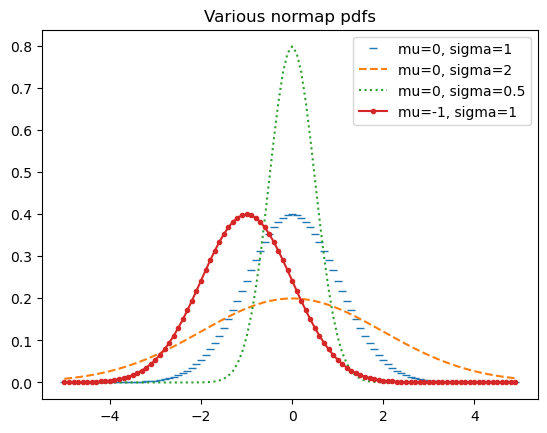

In [33]:
import math
import matplotlib.pyplot as plt

SQRT_TWO_PI = math.sqrt(2*math.pi)
def normal_pdf(x: float, mu: float=0, sigma: float=1) -> float:
    return (math.exp((-(x-mu) ** 2)/(2 * sigma ** 2))/(SQRT_TWO_PI*sigma))

#test
normal_pdf(0.4)
xs = [ x/10.0 for x in range(-50,50) ]
plt.plot(xs, [normal_pdf(x, sigma=1) for x in xs], '_', label ='mu=0, sigma=1')
plt.plot(xs, [normal_pdf(x, sigma=2) for x in xs], '--', label ='mu=0, sigma=2')
plt.plot(xs, [normal_pdf(x, sigma=0.5) for x in xs], ':', label ='mu=0, sigma=0.5')
plt.plot(xs, [normal_pdf(x, mu=-1, sigma=1) for x in xs], '.-', label ='mu=-1, sigma=1')
plt.legend()
plt.title("Various normal pdfs")
plt.show()


The results from the above show that when sigma is larger, the shape gets narrow and tall, conversely when it is < 1, it gets squished and wider.

## The Cumulative Distribution Function for the Normal Distribution

The CDF(z) of the Standard normal is:

$$ 
F(z) = P(Z <= z) = \int^{-\infty} \frac{1}{\sqrt{2 \pi}} e^{-t^2/2} dt
$$



Normal_CDF(1) = 0.8413447460685429


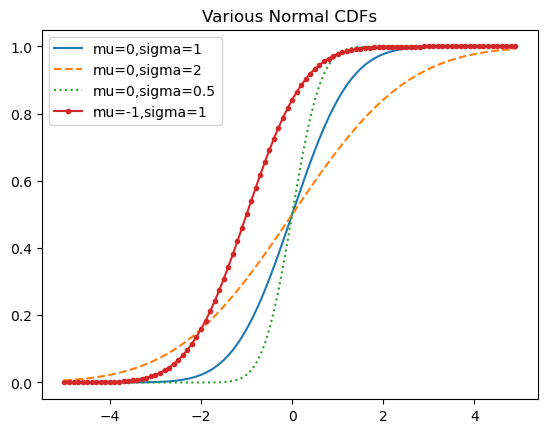

In [53]:
def normal_cdf(x: float, mu: float=0, sigma: float=1) -> float:
    return (1 + math.erf((x-mu) / math.sqrt(2)/ sigma )) /2

print(f"Normal_CDF(1) = {normal_cdf(1)}")

xs = [ x/10.0 for x in range(-50,50) ]
plt.plot(xs, [normal_cdf(x) for x in xs], "-", label="mu=0,sigma=1")
plt.plot(xs, [normal_cdf(x, sigma=2) for x in xs], "--", label="mu=0,sigma=2")
plt.plot(xs, [normal_cdf(x, sigma=0.5) for x in xs], ":", label="mu=0,sigma=0.5")
plt.plot(xs, [normal_cdf(x, mu=-1, sigma=1) for x in xs], ".-", label="mu=-1,sigma=1")
plt.title("Various Normal CDFs")
plt.legend()
plt.show()


## The Inverse Cumulative Distribufion Function
Sometimes we are given a specific probability and we want to find the corresponding X. Deriving the value of $F(z)$ cannot be explicitly written, instead we can use the python error function. So we want to find $z$ given $p$, i.e. solve $F(z) = p$ using numerical techiques. 

Below we use binary search because (as can be seen from the graph above) the function is continous, monotone increasing. As $z$ grows, $F(z)$ grows

Below we use a recursive call just to standardise the variable if the normal distribution is non-standard, i.e. has $\mu != 0$ or $\sigma!=1$. This essentialy converts from $Z$ to $X$:
$$X = \sigma Z + \mu $$

We could have also written this function without recursion and just a simple if statement to adjust the scaling and shifting by the mean at the end of the binary search for non-standard normal distributions.


In [54]:
def inverse_normal_cdf(p: float, mu: float=0, sigma: float=1, tolerance: float =0.0001) -> float:
    """ Find the approximate inverse using binary search """
    #if not standard, compute the standard and rescale
    if mu != 0 or sigma != 1:
       # print("recursion")
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance) # this is essentially making it a standard normal variable

    low_z = -10.0    #normal_cdf(-10) is very close to 0
    high_z = 10.0    #normal_cdf(10) is very close to 1

    while high_z - low_z > tolerance:
        mid_z = (low_z+high_z)/2  #@get the midpoint
        mid_p = normal_cdf(mid_z) 
        #print(f"mid_z = {mid_z}, mid_p = {mid_p}")
        
        if mid_p < p:   
            low_z = mid_z  #midpoint is too low, search above it
        else:
            high_z = mid_z  #midpoint is too hight, search below it

    return mid_z

inverse_normal_cdf(0.8413447460685429)

        

0.9999847412109375